In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Set Seaborn style for better visualizations
sns.set(style="whitegrid")

# Step 1: Create a synthetic dataset based on the prompt
data = {
    'date': pd.date_range(start='2023-01-01', periods=12, freq='ME'),
    'district': ['District A'] * 6 + ['District B'] * 6,
    'waste_generated': [500, 600, 550, 700, 650, 800, 300, 400, 350, 450, 500, 600],  # Example waste generation data
    'raw_material_x': [7500] * 12,  # Fixed value for raw material X
    'raw_material_y': [9000] * 12,  # Fixed value for raw material Y
    'direct_labor_k': [0.20] * 12,   # Fixed value for direct labor K
    'direct_labor_m': [0.10] * 12    # Fixed value for direct labor M
}

# Create DataFrame
df_waste = pd.DataFrame(data)
df_waste

,date,district,waste_generated,raw_material_x,raw_material_y,direct_labor_k,direct_labor_m
0,2023-01-31,District A,500,7500,9000,0.2,0.1
1,2023-02-28,District A,600,7500,9000,0.2,0.1
2,2023-03-31,District A,550,7500,9000,0.2,0.1
3,2023-04-30,District A,700,7500,9000,0.2,0.1
4,2023-05-31,District A,650,7500,9000,0.2,0.1
5,2023-06-30,District A,800,7500,9000,0.2,0.1
6,2023-07-31,District B,300,7500,9000,0.2,0.1
7,2023-08-31,District B,400,7500,9000,0.2,0.1
8,2023-09-30,District B,350,7500,9000,0.2,0.1
9,2023-10-31,District B,450,7500,9000,0.2,0.1


In [12]:
# Step 2: Data Cleaning
## Check for missing values
print("Missing values in each column:")
print(df_waste.isnull().sum())

## Fill missing values with median for numerical columns
imputer = SimpleImputer(strategy='median')
df_waste[['waste_generated', 'raw_material_x', 'raw_material_y', 'direct_labor_k', 'direct_labor_m']] = imputer.fit_transform(
    df_waste[['waste_generated', 'raw_material_x', 'raw_material_y', 'direct_labor_k', 'direct_labor_m']]
)

## Remove duplicates
df_waste.drop_duplicates(inplace=True)

# Step 3: Feature Engineering
## Extract features from the date
df_waste['month'] = df_waste['date'].dt.month
df_waste['year'] = df_waste['date'].dt.year

# Drop original date column
df_waste.drop('date', axis=1, inplace=True)

Missing values in each column:
date               0
district           0
waste_generated    0
raw_material_x     0
raw_material_y     0
direct_labor_k     0
direct_labor_m     0
dtype: int64


In [13]:
# Step 4: Data Normalization
scaler = StandardScaler()
numerical_cols = df_waste.select_dtypes(include=[np.number]).columns
df_waste[numerical_cols] = scaler.fit_transform(df_waste[numerical_cols])

# Encoding Categorical Variables
df_waste = pd.get_dummies(df_waste, drop_first=True)

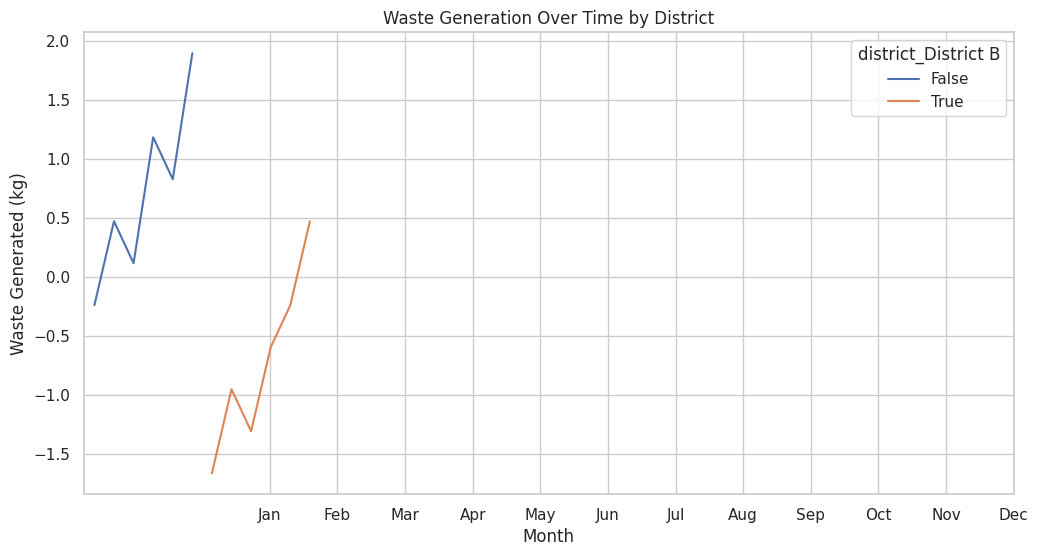

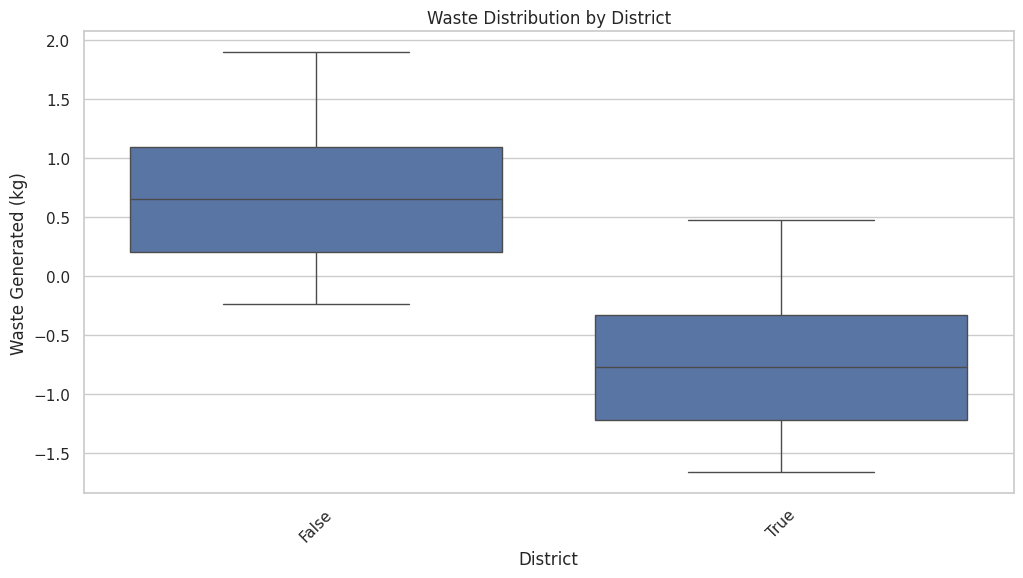

In [14]:
# Step 5: Exploratory Data Analysis
## Visualize waste generation over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_waste, x='month', y='waste_generated', hue='district_District B')
plt.title('Waste Generation Over Time by District')
plt.xlabel('Month')
plt.ylabel('Waste Generated (kg)')
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

## Boxplot for waste distribution by district
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_waste, x='district_District B', y='waste_generated')
plt.title('Waste Distribution by District')
plt.xlabel('District')
plt.ylabel('Waste Generated (kg)')
plt.xticks(rotation=45)
plt.show()

In [15]:
# Step 6: Machine Learning Model
## Define features and target variable
X = df_waste.drop('waste_generated', axis=1)  # Features
y = df_waste['waste_generated']  # Target variable

## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Model Selection and Hyperparameter Tuning
## Define a pipeline for model training
pipeline = Pipeline(steps=[('scaler', StandardScaler()),('model', RandomForestRegressor(random_state=42))]
)
## Define hyperparameters for tuning
param_grid = {'model__n_estimators': [50, 100, 200],
                'model__max_depth': [None, 10, 20, 30],
                'model__min_samples_split': [2, 5, 10]
                }

## Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Step 8: Evaluate the model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R^2 Score: {r2:.2f}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Mean Squared Error: 0.23
Mean Absolute Error: 0.42
R^2 Score: -7.02
